In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
#from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier

# preliminary testing shows outlier DN affect perf much -> we'll ignore it here

In [5]:
colNames = list(range(1024))
colNames.append("label")
df = pd.read_csv('../qsar_oral_toxicity.csv', sep=';',names=colNames)

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,negative
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,negative
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative


In [7]:
df.shape

(8992, 1025)

In [8]:
#checking if values are valid
df.info()
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8992 entries, 0 to 8991
Columns: 1025 entries, 0 to label
dtypes: int64(1024), object(1)
memory usage: 70.3+ MB


0         int64
1         int64
2         int64
3         int64
4         int64
          ...  
1020      int64
1021      int64
1022      int64
1023      int64
label    object
Length: 1025, dtype: object

In [9]:
#label 1 is positive; otherwise negative
df = pd.get_dummies(df)
df.drop("label_negative",1,inplace=True)
df = df.rename({"label_positive":"label"},axis=1)

In [ ]:
df[df["label"]==1].shape
#according to paper's table, this means we have VT data, with ECFP_1024_02 or ECFP_1024_02R

(741, 1025)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8992 entries, 0 to 8991
Columns: 1025 entries, 0 to label
dtypes: int64(1024), uint8(1)
memory usage: 70.3 MB


In [ ]:
df["label"].value_counts()

0    8251
1     741
Name: label, dtype: int64

# Dimensionality reduction using corr map

In [ ]:
a=df.corr()
a

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
0,1.000000,-0.022492,-0.042534,0.027393,-0.007580,-0.029552,0.025832,0.113414,0.089892,0.009939,0.115141,-0.009674,0.168576,0.011919,-0.048482,0.279227,0.318407,0.017465,0.020755,0.041678,0.011413,-0.006701,0.013618,0.123604,0.061193,0.069034,0.086197,0.099963,-0.020414,0.016215,0.043148,0.046193,-0.013538,0.096510,0.014719,0.037900,0.010000,-0.021880,0.370257,0.024299,...,-0.037026,-0.010999,-0.004352,0.044612,0.063260,0.075113,0.002390,0.067835,0.079224,0.115557,-0.074503,0.003279,-0.011516,0.023447,0.023662,0.057418,-0.011364,0.087672,0.097461,0.098068,-0.004462,0.081945,-0.018111,0.103853,0.056558,0.034392,-0.022213,0.013126,0.049442,0.055422,0.016598,0.019205,0.005303,0.019321,-0.005535,0.034860,-0.027423,-0.012507,0.112294,-0.045251
1,-0.022492,1.000000,-0.009623,0.017658,0.000012,0.210397,0.041014,-0.010899,0.044065,0.038704,0.002347,0.053103,0.061304,-0.021335,0.045725,0.000341,-0.071170,-0.007038,-0.005735,0.232404,0.018262,0.305335,0.107131,0.010817,-0.021382,0.008543,-0.003697,0.076075,-0.013658,0.001401,-0.006789,-0.019584,0.052906,0.040798,0.037878,0.009588,0.001948,0.027367,-0.018149,0.006943,...,0.088374,0.012707,0.000151,0.018663,-0.045930,0.009665,0.039609,0.032960,0.066927,0.022265,0.007917,0.095065,-0.014805,0.021740,0.130800,0.052079,0.013386,0.010813,0.007948,0.093975,0.042317,0.274858,-0.030339,0.025566,0.101088,0.257294,0.037455,-0.011177,-0.021554,0.001567,0.010822,-0.001660,-0.027110,-0.015061,0.003191,-0.004363,0.020537,0.060108,0.013688,0.022991
2,-0.042534,-0.009623,1.000000,-0.016200,-0.001773,-0.039329,0.007918,-0.046407,-0.001969,-0.002429,-0.027322,0.042837,0.011967,-0.064073,-0.025287,-0.080187,-0.114769,-0.002625,0.039907,-0.013012,-0.033709,-0.030980,-0.025777,-0.015972,-0.006974,0.005849,-0.021622,0.035592,0.007909,0.038650,0.030586,-0.029169,-0.003794,-0.018909,0.008421,0.009460,-0.023567,-0.019439,-0.023873,-0.027021,...,-0.057533,-0.011211,-0.003749,-0.013451,0.008706,-0.034091,0.002338,0.011244,-0.033494,-0.020746,0.076010,-0.004388,-0.032110,-0.007926,0.039633,-0.000606,0.018387,-0.029435,-0.023110,-0.027710,0.044463,-0.010942,-0.027224,-0.012165,0.049845,-0.029711,0.085438,-0.016328,-0.012367,-0.016034,0.297159,-0.014790,-0.007804,-0.039886,0.035943,0.007165,-0.013458,0.012447,0.014993,0.062461
3,0.027393,0.017658,-0.016200,1.000000,0.038395,0.013307,0.026514,0.093829,0.004583,-0.005713,0.006269,0.057098,0.024677,0.012179,0.029725,0.098908,0.048709,-0.018395,0.024205,0.031408,-0.002194,-0.004199,-0.011007,0.104093,-0.005657,0.005273,0.031050,0.062594,-0.012110,-0.000662,-0.014740,0.030026,0.011633,0.036778,-0.003464,-0.018492,0.001620,0.022456,0.037964,-0.013657,...,0.009081,0.015174,0.038069,0.060536,-0.023270,-0.004984,0.015683,0.004921,0.040395,0.064344,0.008434,0.038483,0.021152,-0.004857,-0.019131,0.011970,-0.000433,0.014068,0.005763,0.024766,0.000724,-0.003326,0.055495,-0.021532,0.010967,0.031540,0.007768,0.076753,-0.004515,-0.002168,0.066144,0.009649,0.074674,-0.003916,-0.015626,0.001663,0.001954,0.001232,0.038928,0.072691
4,-0.007580,0.000012,-0.001773,0.038395,1.000000,0.036584,0.028291,-0.007370,-0.016316,0.000537,0.020565,0.025483,0.029741,0.033720,-0.029806,0.041797,0.003227,0.008669,0.002989,0.042908,-0.012199,0.009833,-0.018400,0.061854,-0.011105,0.058402,0.038474,0.043774,-0.015769,0.011787,-0.017070,0.005812,0.009050,0.057005,0.014601,0.025761,0.037074,0.000014,0.001118,0.036882,...,-0.003177,0.037173,0.004403,-0.004410,-0.005273,0.001338,0.012216,-0.001733,0.013333,0.048692,0.026045,0.023701,0.057425,0.020505,-0.010621,0.009783,-0.005290,0.027324,-0.003342,0.023867,0.010288,0.003645,0.042117,-0.000478,-0.005243,0.030414,0.017828,0.007246,0.009636,0.031682,-0.018131,0.001267

In [ ]:
a[0]

0        1.000000
1       -0.022492
2       -0.042534
3        0.027393
4       -0.007580
           ...   
1020     0.034860
1021    -0.027423
1022    -0.012507
1023     0.112294
label   -0.045251
Name: 0, Length: 1025, dtype: float64

In [10]:
#check for collinearity
#https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on

# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix (not including diagonal)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
df.drop(to_drop, axis=1, inplace=True)

In [20]:
to_drop

[53, 405, 408, 424, 473, 646, 656, 657, 683, 685, 758, 759, 819, 871, 960]

In [44]:
a=[2,4]
b =[0,1,2,3,4]
#np.where(b not in a)

In [47]:
b.pop(1)
b

[0, 4]

In [50]:
def delete_multiple_element(list_object, indices):
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
            print("before:", list_object)
            list_object.pop(idx)
            print("after:", list_object)
list_of_num = [51, 52, 53, 54, 55, 56, 57, 58, 59]
list_of_indices = [4, 2, 6]
# Remove elements from list_of_num at index 4,2 and 6
delete_multiple_element(list_of_num, list_of_indices)
print(list_of_num)

before: [51, 52, 53, 54, 55, 56, 57, 58, 59]
after: [51, 52, 53, 54, 55, 56, 58, 59]
before: [51, 52, 53, 54, 55, 56, 58, 59]
after: [51, 52, 53, 54, 56, 58, 59]
before: [51, 52, 53, 54, 56, 58, 59]
after: [51, 52, 54, 56, 58, 59]
[51, 52, 54, 56, 58, 59]


# Continue w/ splitting train,test sets

In [11]:
#train, test split
train, test=train_test_split(df, test_size=0.3, random_state=1)
train.reset_index(drop=True, inplace=True)

In [ ]:
#######<--

In [ ]:
#######-->

In [ ]:
train["label"].value_counts()

0    5765
1     529
Name: label, dtype: int64

In [ ]:
#!pip install imblearn

In [ ]:
#upsampling: https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#t10
#from imblearn.over_sampling import SMOTE

#smote = SMOTE(random_state=12, sampling_strategy=1)#'minority')

In [12]:
X_train=train.drop(["label"],1)
y_train=train["label"]

# Optimizing Params - Grid Search

In [ ]:
#https://stackoverflow.com/questions/58815016/cross-validating-with-imblearn-pipeline-and-gridsearchcv
#define some functions to automate Grid search

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV

def imb_pipeline(clf, X, y, params):

    model = Pipeline([
        ('sampling', SMOTE(random_state=1, sampling_strategy=1)),
        ('classification', clf)
    ])
    #optimizing accuracy instead of balanced_accuracy score bc we upsampled and have a balanced training set; can check balanced_accuracy score later, make suree it is low
    score={'ACCURACY':'accuracy', 'RECALL':'recall', 'F1':'f1'}

    gcv = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, scoring=score, n_jobs=12, refit='ACCURACY')
    gcv.fit(X, y)

    return gcv

def print_scores(grid_result):
    print("Best ACCURACY: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_ACCURACY']
    stds = grid_result.cv_results_['std_test_ACCURACY']
    means2 = grid_result.cv_results_['mean_test_RECALL']
    stds2 = grid_result.cv_results_['std_test_RECALL']
    means3 = grid_result.cv_results_['mean_test_F1']
    stds3 = grid_result.cv_results_['std_test_F1']
    params = grid_result.cv_results_['params']
    print("ACCURACY, RECALL, F1 with PARAMS")
    for mean, std, mean2, std2, mean3, std3, param in zip(means, stds, means2, stds2, means3, stds3, params):
        print("%f (%f), %f (%f), %f (%f) with: %r" % (mean, std, mean2, std2, mean3, std3, param))

In [ ]:
from scipy.stats import loguniform

classifiers = LogisticRegression(C=1.0, penalty='l2',
                     random_state=None, tol=0.0001, verbose=0,
                     warm_start=False)

#see solver in https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
params = [{'classification__penalty':['elasticnet'],
          'classification__solver':['saga'],
          'classification__C': loguniform(1e-5, 100)},
          {'classification__penalty':['none','l2'],
          'classification__solver':['newton-cg', 'lbfgs', 'sag','saga'],
          'classification__C': loguniform(1e-5, 100)},
          {'classification__penalty':['l1'],
          'classification__solver':('liblinear','saga'),
          'classification__C': loguniform(1e-5, 100)}
         ]

        
    
#for param, classifier in zip(params, classifiers):
grid_result = imb_pipeline(classifiers, X_train, y_train, params) 

#print
print_scores(grid_result)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best ACCURACY: 0.915952 using {'classification__C': 0.00032348093879459985, 'classification__penalty': 'l1', 'classification__solver': 'liblinear'}
ACCURACY, RECALL, F1 with PARAMS
nan (nan), nan (nan), nan (nan) with: {'classification__C': 0.00026691998147981697, 'classification__penalty': 'elasticnet', 'classification__solver': 'saga'}
0.869079 (0.010081), 0.563199 (0.036261), 0.420247 (0.032522) with: {'classification__C': 0.09505735596622167, 'classification__penalty': 'l1', 'classification__solver': 'liblinear'}
nan (nan), nan (nan), nan (nan) with: {'classification__C': 10.528443232906744, 'classification__penalty': 'elasticnet', 'classification__solver': 'saga'}
0.860501 (0.007608), 0.498994 (0.025112), 0.375691 (0.014773) with: {'classification__C': 0.032475668260629115, 'classification__penalty': 'none', 'classification__solver': 'newton-cg'}
nan (nan), nan (nan), nan (nan) with: {'classification__C': 0.020583368903385264, 'classification__penalty': 'elasticnet', 'classificati

In [ ]:
from scipy.stats import randint

classifiers = RandomForestClassifier(n_estimators=50)

#some selected params in https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
params = {'classification__n_estimators': randint(10, 1000), 'classification__max_depth': randint(10,100),
         'classification__criterion':('gini', 'entropy'), 'classification__max_features':('auto', 'sqrt', 'log2')}
    
#for param, classifier in zip(params, classifiers):
grid_result = imb_pipeline(classifiers, X_train, y_train, params) 

#print
print_scores(grid_result)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best ACCURACY: 0.930568 using {'classification__criterion': 'entropy', 'classification__max_depth': 63, 'classification__max_features': 'auto', 'classification__n_estimators': 603}
ACCURACY, RECALL, F1 with PARAMS
0.922465 (0.007166), 0.549937 (0.042272), 0.543923 (0.040111) with: {'classification__criterion': 'entropy', 'classification__max_depth': 30, 'classification__max_features': 'sqrt', 'classification__n_estimators': 622}
0.928344 (0.004393), 0.510225 (0.046554), 0.544007 (0.031830) with: {'classification__criterion': 'gini', 'classification__max_depth': 58, 'classification__max_features': 'sqrt', 'classification__n_estimators': 330}
0.928979 (0.004266), 0.525337 (0.049249), 0.553291 (0.036819) with: {'classification__criterion': 'entropy', 'classification__max_depth': 68, 'classification__max_features': 'sqrt', 'classification__n_estimators': 451}
0.930568 (0.003652), 0.525337 (0.051024), 0.558675 (0.034542) with: {'classification__criterion': 'entropy', 'classification__max_de

In [ ]:
import numpy
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import uniform
from scipy.stats import randint
from scipy.stats import loguniform

#setting up NN model 
def setUpModel(n1, n2, lr=0.001, momentums=0.9):
    #set up and compile a model
    model = keras.Sequential()
    
    model.add(layers.Dense(n1, input_dim=X_train.shape[1], activation="sigmoid"))
    model.add(layers.Dense(n2, activation="sigmoid"))
    model.add(layers.Dense(1, activation="sigmoid")) #1 output layer bc of binary output
    
    model.compile(loss='mse',
         optimizer = keras.optimizers.SGD(momentum=momentums, learning_rate=lr),
         metrics=['accuracy',
             keras.metrics.Recall(name="recall", thresholds=0.3)
                 ])
        
    return model

#create a scikilearn-compatible model
Kmodel = KerasClassifier(build_fn=setUpModel, verbose=0, batch_size=100, epochs=100)
# define the grid search parameters
neurons1 = (5, 10, 15, 20)
neurons2 = (5, 10, 15, 20)
lr = [0.005,0.01,0.05,0.1]
momentum = [0.1, 0.4,0.7,0.9,0.99]
params = {"classification__n1":randint(5,15), "classification__n2":randint(5,15),
         "classification__lr":loguniform(0.0001,10), "classification__momentums": uniform(0.01,0.999999)}

#for param, classifier in zip(params, classifiers):
grid_result = imb_pipeline(Kmodel, X_train, y_train, params) 

#print
print_scores(grid_result)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best ACCURACY: 0.923100 using {'classification__lr': 2.9022763719154856, 'classification__momentums': 0.7352085063534269, 'classification__n1': 8, 'classification__n2': 12}
ACCURACY, RECALL, F1 with PARAMS
0.783921 (0.013301), 0.614148 (0.047013), 0.323428 (0.034362) with: {'classification__lr': 0.008732680554832022, 'classification__momentums': 0.24091055904946754, 'classification__n1': 8, 'classification__n2': 10}
0.593771 (0.193742), 0.558980 (0.178260), 0.202722 (0.043780) with: {'classification__lr': 0.0007694890286435386, 'classification__momentums': 0.483614091650539, 'classification__n1': 6, 'classification__n2': 5}
0.913885 (0.005900), 0.475449 (0.057427), 0.479739 (0.049926) with: {'classification__lr': 0.5241304444212942, 'classification__momentums': 0.3853443709845092, 'classification__n1': 6, 'classification__n2': 11}
0.921035 (0.003372), 0.498865 (0.092580), 0.509713 (0.065847) with: {'classification__lr': 8.40951537676506, 'classification__momentums': 0.5045174303321805,

In [ ]:
X_test = test.drop(["label"],1)
y_test = test["label"]

# Test model result consistency

In [ ]:
import numpy
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import uniform

def setUpModel(n1, n2, lr=0.001, momentums=0.9):
    #set up and compile a model
    model = keras.Sequential()
    
    model.add(layers.Dense(n1, input_dim=X_train.shape[1], activation="sigmoid"))
    model.add(layers.Dense(n2, activation="sigmoid"))
    model.add(layers.Dense(1, activation="sigmoid")) #1 output layer bc of binary output
    
    model.compile(loss='mse',
         optimizer = keras.optimizers.SGD(momentum=momentums, learning_rate=lr),
         metrics=['accuracy',
             keras.metrics.Recall(name="recall", thresholds=0.5)
                 ])
        
    return model

model = setUpModel(lr=8.4095,momentums=0.5045,n1=7,n2=10)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=1, sampling_strategy=1)#'minority')
Xtt, ytt = smote.fit_resample(train.drop(["label"],1), train["label"])
#fit
model.fit(Xtt, ytt, batch_size=100, epochs=100, verbose=0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
np.where(model.predict(X_train) > 0.5)[0]
#X_train.shape
#model.predict(X_train)
model.predict(X_train)[13]

array([0.9990144], dtype=float32)

In [ ]:
model.evaluate(X_train, y_train)

197/197 [==============================] - 0s 1ms/step - loss: 0.0116 - accuracy: 0.9881 - recall: 0.9017


[0.011638537980616093, 0.9880838990211487, 0.9017013311386108]

In [ ]:
model.evaluate(X_test, y_test)

85/85 [==============================] - 0s 1ms/step - loss: 0.0666 - accuracy: 0.9266 - recall: 0.5047


[0.06657195091247559, 0.9266123175621033, 0.5047169923782349]

# Acc, F1, Recall vs Threshold 

In [13]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

def getAcc(y_true, y_pred):
    number_matches = len(np.where((y_true==y_pred) == True)[0])
    total_sample = len(y_true)
    return number_matches/total_sample

def getBalAcc(y_true, y_pred):
    tn, total_neg = 0, 0
    tp, total_pos = 0, 0
    for i in range(len(y_true)):
        if y_true[i]==1:
            total_pos+=1
            if y_pred[i]==1:
                tp+=1
        else:
            total_neg +=1
            if y_pred[i]==0:
                tn+=1
    return (tn/total_neg + tp/total_pos)/2

def AFRvsTh_graph(X_test, y_test, sk_model): #fitted model
    pred = sk_model.predict_proba(X_test)
    
    #plot recall
    pre, rec, th = precision_recall_curve(y_test, pred[:,1])
    plt.plot(th, rec[:-1], color = 'b', label='Recall score')
    
    #plot f1
    f1 = 2*pre[:-1]*rec[:-1]/(pre[:-1]+rec[:-1])
    plt.plot(th, f1, color = 'g', label='F1 score')
    
    #plot accuracy and balanced accuracy
    th_for_acc = np.linspace(0,1,100)
    acc=[]
    bal_acc=[]
    for i in range(len(th_for_acc)):
        y_out = pred[:,1]
        y_out = np.where(y_out>=th_for_acc[i], 1, y_out) #convert prob to 1 if prob[i]>=threshold
        y_out = np.where(y_out!=1, 0, y_out) #convert prob to 0 if prob[i]<threshold
        acc.append(getAcc(y_test, y_out))
        bal_acc.append(getBalAcc(list(y_test), list(y_out)))
    plt.plot(th_for_acc, acc, linestyle='--', color = 'r', label='Accuracy score')
    plt.plot(th_for_acc, bal_acc, linestyle='--', color = 'c', label='Balanced accuracy score')
    
    plt.xlabel("Threshold")
    plt.ylabel("Percentage")
    plt.legend()
    plt.show()

def balAcc_rec_f1(y_true, y_pred):
    tn, fn, total_neg = 0, 0, 0
    tp, fp, total_pos = 0, 0, 0
    for i in range(len(y_true)):
        if y_true[i]==1:
            total_pos+=1
            if y_pred[i]==1:
                tp+=1
            else:
                fn+=1
        else:#y_true[i]==0
            total_neg +=1
            if y_pred[i]==0:
                tn+=1
            else:
                fp+=1
    #print(tn, fn, total_neg, tp, fp, total_pos)
    b_acc = (tn/total_neg + tp/total_pos)/2
    rec = tp/total_pos
    if tp+fp != 0:
        prec = tp/(tp+fp)
    else:
        prec = 1
    f1 = 2*rec*prec/(rec+prec)
    return b_acc,rec,f1

def AFRvsTh_graph_Keras(X_test, y_test, keras_model): #fitted model
    pred = keras_model.predict(X_test).reshape(1,-1)[0]
    
    #plot 4 metrics
    th_for_acc = np.linspace(0,1,100)
    acc=[]
    bal_acc=[]
    rec=[]
    f1=[]
    for i in range(len(th_for_acc)):
        y_out = pred
        y_out = np.where(y_out>=th_for_acc[i], 1, y_out) #convert prob to 1 if prob[i]>=threshold
        y_out = np.where(y_out!=1, 0, y_out) #convert prob to 0 if prob[i]<threshold
        acc.append(getAcc(y_test, y_out))
        b_acc_score, r_score, f1_score = balAcc_rec_f1(list(y_test), list(y_out))
        bal_acc.append(b_acc_score)
        rec.append(r_score)
        f1.append(f1_score)
    plt.plot(th_for_acc, acc, linestyle='--', color = 'r', label='Accuracy score')
    plt.plot(th_for_acc, bal_acc, linestyle='--', color = 'c', label='Balanced accuracy score')
    plt.plot(th_for_acc[:-1], f1[:-1], color = 'g', label='F1 score') #last one is precission=0 -> DN count; last val here counts as trash
    plt.plot(th_for_acc, rec, color = 'b', label='Recall score')

    plt.xlabel("Threshold")
    plt.ylabel("Percentage")
    plt.legend()
    plt.show()

In [81]:
np.linspace(0,1,100)

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [ ]:
import numpy as np
a = np.array([1,2,3,0,0,0,1,1,1])
b = np.where(a==0,10,a)
b = np.where(b!=10,0,b)
b

array([ 0,  0,  0, 10, 10, 10,  0,  0,  0])

0.75

In [62]:
from imblearn.over_sampling import SMOTE
import numpy
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def setUpModel(n1, n2, lr=0.001, momentums=0.9):
    #set up and compile a model
    model = keras.Sequential()
    
    model.add(layers.Dense(n1, input_dim=X_train.shape[1], activation="sigmoid"))
    model.add(layers.Dense(n2, activation="sigmoid"))
    model.add(layers.Dense(1, activation="sigmoid")) #1 output layer bc of binary output
    
    model.compile(loss='mse',
         optimizer = keras.optimizers.SGD(momentum=momentums, learning_rate=lr),
         metrics=['accuracy',
             keras.metrics.Recall(name="recall", thresholds=0.5)
                 ])
        
    return model

#upsample
smote = SMOTE(random_state=1, sampling_strategy=1)#'minority')
Xtt, ytt = smote.fit_resample(train.drop(["label"],1), train["label"])

#models
lr_model = LogisticRegression(C=0.1659, penalty='l1', solver='liblinear',
                     random_state=None, tol=0.0001, verbose=0,
                     warm_start=False)
rf_model = RandomForestClassifier(criterion="entropy", max_depth=63, max_features="auto", n_estimators=603)

model = setUpModel(lr=8.4095,momentums=0.5045,n1=7,n2=10)
model.fit(Xtt, ytt, batch_size=100, epochs=100, verbose=0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [16]:
#upsample; tesing for web app
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=1, sampling_strategy=1)#'minority')
Xtt, ytt = smote.fit_resample(train.drop(["label"],1), train["label"])
rf_model = RandomForestClassifier(criterion="entropy", max_depth=63, max_features="auto", n_estimators=603)
rf_model.fit(Xtt, ytt)

RandomForestClassifier(criterion='entropy', max_depth=63, n_estimators=603)

In [52]:
data_input="0000000000100000100000000000000000000000100000000000000000000000000000000000001000100000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000111000010000000010000000000000000000000000001001000000000000000000000000000000000000000001000000000000000000001000000000000000000000000000000000100000000000000000001000000000000000000000000000000000000000000000010000000000000001000000001000000000000000000100010000000000000000000010000001010000010000000000000000000100000000000000000000000000000000000000000000000000000000000000010000000000010000000000000000000010000000000010000000000000001000000000010000000000100000100000000010000000010000000000000000000100000000000000000000000000001000000000000000000000000100000000000000000011000000000000000000000000001010000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000010000000000000000000000010000001000000000000000000000001000000000100000100000000100010000000000000000000000000000000000"
data_array = [int(x) for x in data_input]

In [53]:
def delete_multiple_element(list_object, indices):
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
            #print("before:", list_object)
            list_object.pop(idx)
            #print("after:", list_object)
delete_multiple_element(data_array, to_drop)

In [67]:
a = 0
if not a:
    print("y")
else:
    print("n")

y


In [93]:
a=[1,2,3]

In [96]:
a.pop()

2

In [97]:
a

[1]

In [59]:
rf_model.predict_proba([data_array])[:,1][0]

0.011608623548922056

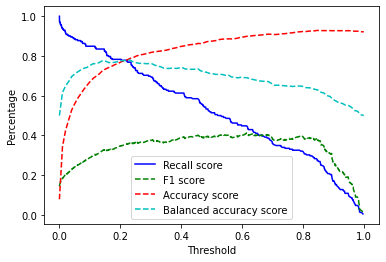

In [ ]:
lr_model.fit(Xtt, ytt)
AFRvsTh_graph(sk_model=lr_model, X_test=X_test, y_test=y_test)

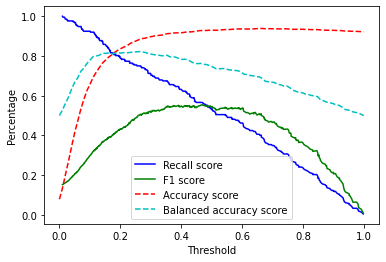

In [ ]:
rf_model.fit(Xtt, ytt)
AFRvsTh_graph(sk_model=rf_model, X_test=X_test, y_test=y_test)

361/361 [==============================] - 0s 1ms/step - loss: 0.0165 - accuracy: 0.9815 - recall: 0.9743


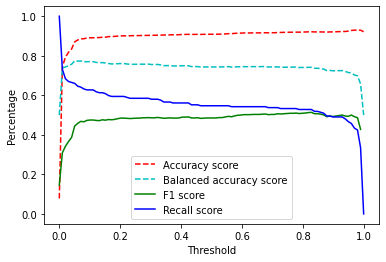

In [87]:
model.fit(Xtt, ytt)
#model.predict(X_test).reshape(1,-1)[0]
AFRvsTh_graph_Keras(keras_model=model, X_test=X_test, y_test=y_test)

In [ ]:
def ag(d=0):
    if 0:
        print("yes")
    else:
        print("no")
    
ag()

no


# Result (using best parameters)

## Precision, Recall vs Threshold

In [ ]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

train["label"].value_counts()

0    5765
1     529
Name: label, dtype: int64

In [ ]:
#log
X_test = test.drop(["label"],1)
y_test = test["label"]

log = LogisticRegression(C=0.1, max_iter=2000)

log.fit(X_train, y_train)

#plot_precision_recall_curve(log, X_test, y_test)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_scores=log.predict_proba(X_test)
prec, rec, tre = precision_recall_curve(y_test, y_scores[:,1])
plt.plot(tre, prec[:-1], linestyle='--', label='Precision')
plt.plot(tre, rec[:-1], linestyle='--', color = 'b', label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Scores")
plt.legend()
plt.show()

KeyboardInterrupt: ignored

In [ ]:
#forest; grid search 2 vars
classifier = RandomForestClassifier(n_estimators=500, max_depth=70)
classifier.fit(X_train, y_train)
#plot_precision_recall_curve(classifier, X_test, y_test)
y_scores=classifier.predict_proba(X_test)
prec, rec, tre = precision_recall_curve(y_test, y_scores[:,1])
plt.plot(tre, prec[:-1], linestyle='--', label='Precision')
plt.plot(tre, rec[:-1], linestyle='--', color = 'b', label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Scores")
plt.legend()
plt.show()

In [ ]:
def setUpModel(n1=5, n2=5):
    #set up and compile a model
    model = keras.Sequential()
    
    model.add(layers.Dense(n1, input_dim=X_train.shape[1], activation="sigmoid"))
    model.add(layers.Dense(n2, activation="sigmoid"))
    model.add(layers.Dense(1, activation="sigmoid")) #1 output layer bc of binary output
    
    model.compile(loss='mse',
         optimizer = keras.optimizers.SGD(momentum=0.99, learning_rate=0.01),
         metrics=['accuracy',
             keras.metrics.Recall(name="recall", thresholds=0.3)
                 ])
        
    return model

#create a scikilearn-compatible model
Kmodel = KerasClassifier(build_fn=setUpModel, verbose=0, batch_size=1000, epochs=30)
Kmodel.fit(X_train, y_train)
#plot_precision_recall_curve(Kmodel, X_test, y_test)

In [ ]:
y_scores=Kmodel.predict_proba(X_test)
prec, rec, tre = precision_recall_curve(y_test, y_scores[:,1])
plt.plot(tre, prec[:-1], linestyle='--', label='Precision')
plt.plot(tre, rec[:-1], linestyle='--', color = 'b', label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Scores")
plt.legend()
plt.show()

In [ ]:
prec

In [ ]:
plt.plot(rec,prec )

## ROC